In [27]:
# 1. IMPORT REQUIRED LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Sklearn utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')



In [28]:
# Fix seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ==========================================
# 2. Download Stock Data
# ==========================================
ticker = "AAPL"   # change to any stock
data = yf.download(ticker, start="2015-01-01", end="2024-01-01")

df = data[['Close']].copy()

[*********************100%***********************]  1 of 1 completed


In [29]:
# 3. SCALE DATA

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [30]:
# 4. CREATE SEQUENCES (WINDOW SIZE = 30)
def create_sequences(data, window_size=30):
    X = []
    y = []
    
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # previous 30 days
        y.append(data[i])                # next day
    
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(data_scaled, window_size)

In [31]:
# 5. SPLIT DATA (70/20/10)


total_size = len(X)

train_size = int(total_size * 0.7)
val_size   = int(total_size * 0.2)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (857, 30, 1)
Val: (245, 30, 1)
Test: (123, 30, 1)


In [32]:
# 6. CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

In [33]:
# 7. MODEL A - SIMPLE RNN
rnn_model = Sequential()

# SimpleRNN layer
rnn_model.add(SimpleRNN(units=50,activation='tanh',input_shape=(window_size, 1)))

# Output layer
rnn_model.add(Dense(1))

# Compile model
rnn_model.compile(optimizer=Adam(),loss='mse')

# Train model
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop, lr_scheduler],verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0191 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5446e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2691e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5123e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0353e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7369e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5565e-04 - val_loss: 0.0016 - learning_rate: 0

In [34]:
# 8. MODEL B - LSTM


lstm_model = Sequential()

# LSTM layer
lstm_model.add(LSTM(
    units=50,
    activation='tanh',
    input_shape=(window_size, 1)
))

# Output layer
lstm_model.add(Dense(1))

# Compile model
lstm_model.compile(
    optimizer=Adam(),
    loss='mse'
)

# Train model
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0249 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0033 - learning_rate: 5.0000e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0030 - learning_rate: 5.0000e-04

In [35]:
# 9. EVALUATION

# RNN Predictions
rnn_pred = rnn_model.predict(X_test)
rnn_pred = scaler.inverse_transform(rnn_pred)
y_test_actual = scaler.inverse_transform(y_test)

# LSTM Predictions
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# Metrics
rnn_mse = mean_squared_error(y_test_actual, rnn_pred)
rnn_mae = mean_absolute_error(y_test_actual, rnn_pred)

lstm_mse = mean_squared_error(y_test_actual, lstm_pred)
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)

print("RNN Test MSE:", rnn_mse)
print("RNN Test MAE:", rnn_mae)

print("LSTM Test MSE:", lstm_mse)
print("LSTM Test MAE:", lstm_mae)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AC3B5D1B40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
RNN Test MSE: 35.79284534918675
RNN Test MAE: 4.920829323069061
LSTM Test MSE: 1806.4048470655475
LSTM Test MAE: 41.823222416300354


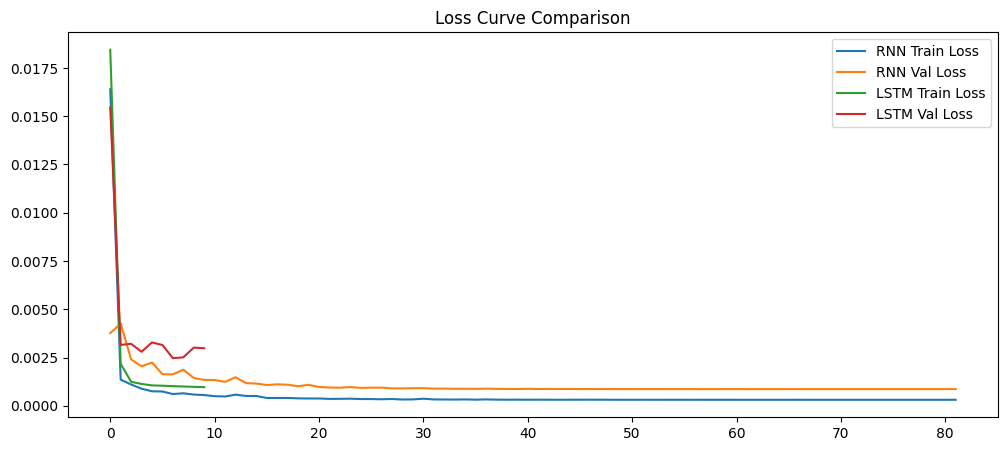

In [23]:
# 10. LOSS CURVES

plt.figure(figsize=(12,5))

plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')

plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')

plt.legend()
plt.title("Loss Curve Comparison")
plt.show()

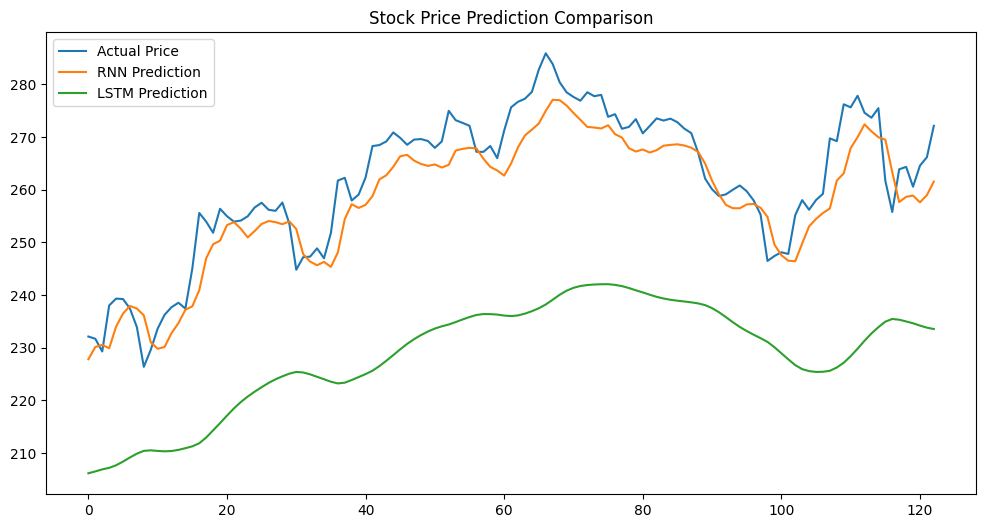

In [24]:
# 11. PREDICTION VISUALIZATION

plt.figure(figsize=(12,6))

plt.plot(y_test_actual, label='Actual Price')
plt.plot(rnn_pred, label='RNN Prediction')
plt.plot(lstm_pred, label='LSTM Prediction')

plt.legend()
plt.title("Stock Price Prediction Comparison")
plt.show()